In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json
import collections
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
rec = pd.read_hdf('/Users/arielle/Downloads/recipe_desserts', 'desserts')
rec = rec.rename(columns={'id': 'recipe_id'})
rec.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,ingredients-clean
30,get the sensation brownies,27087,70,37305,2002-05-03,"['weeknight', 'time-to-make', 'course', 'main-...","[174.4, 13.0, 67.0, 5.0, 4.0, 26.0, 7.0]",11,"['preheat oven to 350 degrees', 'grease 13 x 9...",a yummy thick chocolate mint brownie from york...,"['butter', 'sugar', 'vanilla', 'eggs', 'all-pu...",9,"['unsalted-butter', 'granulated-sugar', 'vanil..."
72,one pot brownies,32271,40,41809,2002-06-25,"['60-minutes-or-less', 'time-to-make', 'course...","[1389.5, 129.0, 410.0, 26.0, 42.0, 211.0, 51.0]",8,"['melt chocolate and butter in heavy pot', 'le...",this recipe was submitted by mrs. stuart padno...,"['unsweetened chocolate squares', 'butter', 's...",7,"['unsweetened-chocolate', 'unsalted-butter', '..."
94,symphony brownies,44895,45,51224,2002-10-29,"['60-minutes-or-less', 'time-to-make', 'course...","[5728.3, 470.0, 1941.0, 87.0, 140.0, 443.0, 22...",10,"['preheat oven to 350 degrees , or 325 degrees...",a,"['betty crocker fudge brownie mix', 'eggs', 'w...",5,"['betty crocker fudge brownie mix', 'eggs', 'c..."
103,turtle squares,58651,30,35635,2003-04-07,"['30-minutes-or-less', 'time-to-make', 'course...","[172.4, 16.0, 51.0, 1.0, 2.0, 26.0, 6.0]",15,"['preheat oven to 350 degrees f', 'spray a 13 ...",for lovers of pecans and chocolate...,"['flour', 'brown sugar', 'butter', 'pecans', '...",5,"['all-purpose-flour', 'brown sugar', 'unsalted..."
111,1 brownies in the world best ever,333281,40,985201,2008-10-27,"['60-minutes-or-less', 'time-to-make', 'course...","[138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",9,"['bittersweet chocolate', 'unsalted-butter', '..."


In [3]:
# Load in recipe ratings
ratings_filename = '/Users/arielle/Downloads/RAW_interactions.csv'
reviews = pd.read_csv(ratings_filename)

In [4]:
print('Unique rating values: ' + str(set(reviews.rating)))
print(reviews.dtypes)
reviews.head()

Unique rating values: {0, 1, 2, 3, 4, 5}
user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [5]:
# calculate average rating per recipe, and number of reviews per recipe
rating_mean = reviews.groupby('recipe_id').mean().rating
rating_num = reviews.groupby('recipe_id').count()

In [6]:
# only include data from recipes with at least 20 reviews
df_rating = pd.DataFrame({'rating_mean': rating_mean, 'number_of_reviews': rating_num.review})
df_rating = df_rating[df_rating.number_of_reviews >= 20]

In [7]:
# merge recipe & rating data frames
df = rec.merge(df_rating, on='recipe_id', how='left')
df = df.dropna()

# of ingredients accounts for 2.0 % of variance of average ratings
R squared = 0.0203856654268


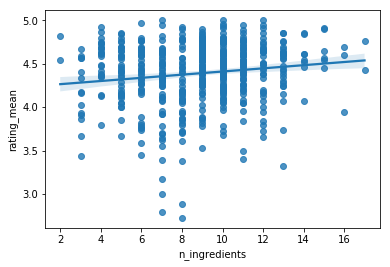

In [8]:
# is # of ingredients related to average rating?
sns.regplot(x='n_ingredients',y='rating_mean',data=df)

x = np.array(df.n_ingredients).reshape(-1, 1)
y = np.array(df.rating_mean).reshape(-1, 1)
res = LinearRegression().fit(x, y)
print('# of ingredients accounts for ' + str(np.round(100*res.score(x, y))) + ' % of variance of average ratings')
print('R squared = ' + str(res.score(x, y)))

In [9]:
# Get a master list of all ingredients 
master_list = []

# loop over recipes
for idx in df.index:

    # list of ingredients for each recipe
    curr_ingred = eval(df.loc[idx, 'ingredients-clean'])
    
    for each in curr_ingred:
        master_list.append(each)
        
# Obtain a unique list ingredients w/ # of occurances --> which ones are most common?
master_dict = collections.Counter(master_list)

In [10]:
# Sort unique ingredient list to see which ingredients are most common
nums = np.array(list(master_dict.values()))
labels = np.array(list(master_dict.keys()))

sort_idx = np.argsort(-nums)
nums_sort = nums[sort_idx]
labels_sort = labels[sort_idx]

# Show the top ingredients - those appearing in at least 5 recipes
n_keep = np.where(nums_sort >= 5)[0].max()

In [11]:
for idx in df.index:
    curr_ingred = eval(df.loc[idx, 'ingredients-clean'])
    for each in curr_ingred:
        if each in labels_sort[:n_keep]:
            df.loc[idx,each] = True

for ingred_list in labels_sort[:n_keep]:
    df.loc[df[ingred_list].isna(), ingred_list] = False

In [13]:
# matrix of predictors - is an ingredient present or absent in each recipe
X = np.zeros((df.shape[0], n_keep))
rsquare = np.zeros((n_keep))
y = np.array(df.rating_mean)
for idx,ingred in enumerate(labels_sort[:n_keep]):
    X[:,idx] = df[ingred]
    res = LinearRegression().fit(X[:,idx].reshape(-1,1), y)
    rsquare[idx] = res.score(X[:,idx].reshape(-1,1), y)

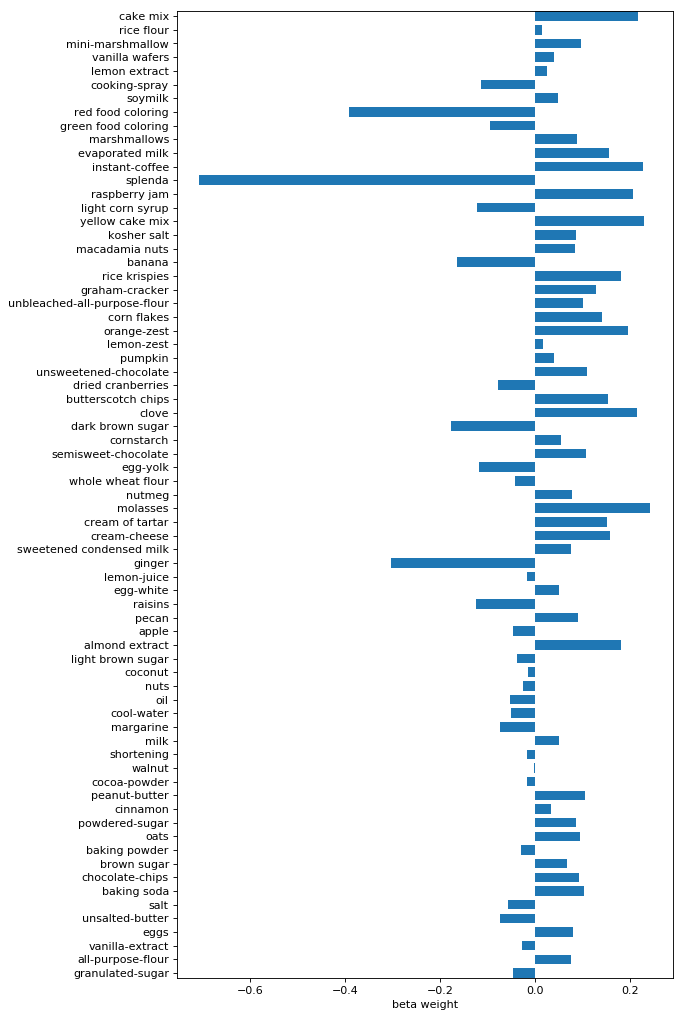

In [14]:
res = LinearRegression().fit(X, y)
betas = res.coef_

x = np.arange(0, len(betas))

plt.figure(figsize=(8, 16), dpi=80)
plt.barh(y=x, width=betas, height=.7)

plt.yticks(x, (labels_sort[:n_keep]))
plt.xlabel('beta weight')
plt.margins(y=0)

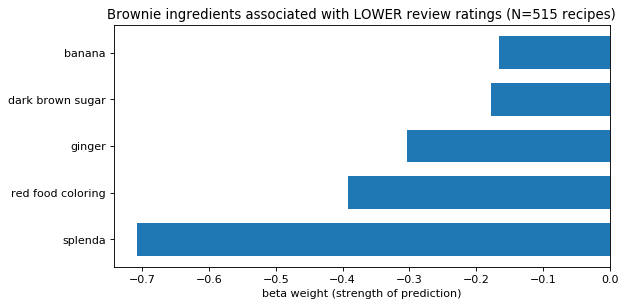

In [70]:
# gather top 5 strongest negative & positive predictors of recipe ratings

betas_sort_idx = np.argsort(betas)
n = 5
betas_neg_idx = betas_sort_idx[0:n]
betas_pos_idx = betas_sort_idx[-n:len(betas_sort_idx)]
betas_idx = np.hstack((betas_neg_idx, betas_pos_idx))
betas_sort = betas[betas_idx]

x = np.arange(0, n)
labels = labels_sort[:n_keep]

plt.figure(figsize=(8, 4), dpi=80)
# plt.subplot(1,2,1)
plt.barh(y=np.arange(0, n), width=betas[betas_neg_idx], height=.7)
plt.yticks(x, (labels[betas_neg_idx]))
plt.title('Brownie ingredients associated with LOWER review ratings (N=' + str(df.shape[0]) + ' recipes)')
plt.xlabel('beta weight (strength of prediction)')

np.where(labels_sort[:n_keep]=='splenda')[0]
idx = labels_sort[:n_keep]=='splenda'
y_abs = y[np.where(X[:,idx]==False)[0]]
y_pres = y[np.where(X[:,idx]==True)[0]]
plt.savefig('negative_predictors.png', bbox_inches='tight')

# plt.subplot(1,2,2)
# plt.bar(0, np.mean(y_abs))
# plt.bar(1, np.mean(y_pres))

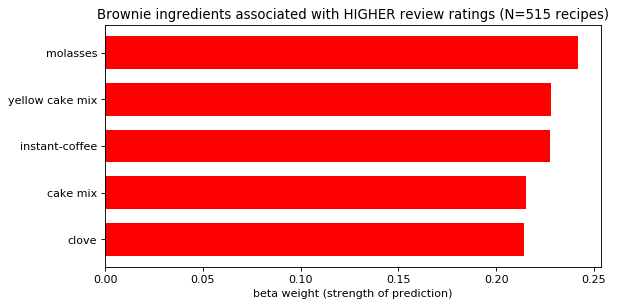

In [69]:
plt.figure(figsize=(8, 4), dpi=80)
plt.barh(y=np.arange(0, n), width=betas[betas_pos_idx], height=.7, color='red')
plt.yticks(x, (labels[betas_pos_idx]))
plt.title('Brownie ingredients associated with HIGHER review ratings (N=' + str(df.shape[0]) + ' recipes)')

plt.xlabel('beta weight (strength of prediction)')
plt.savefig('positive_predictors.png', bbox_inches='tight')


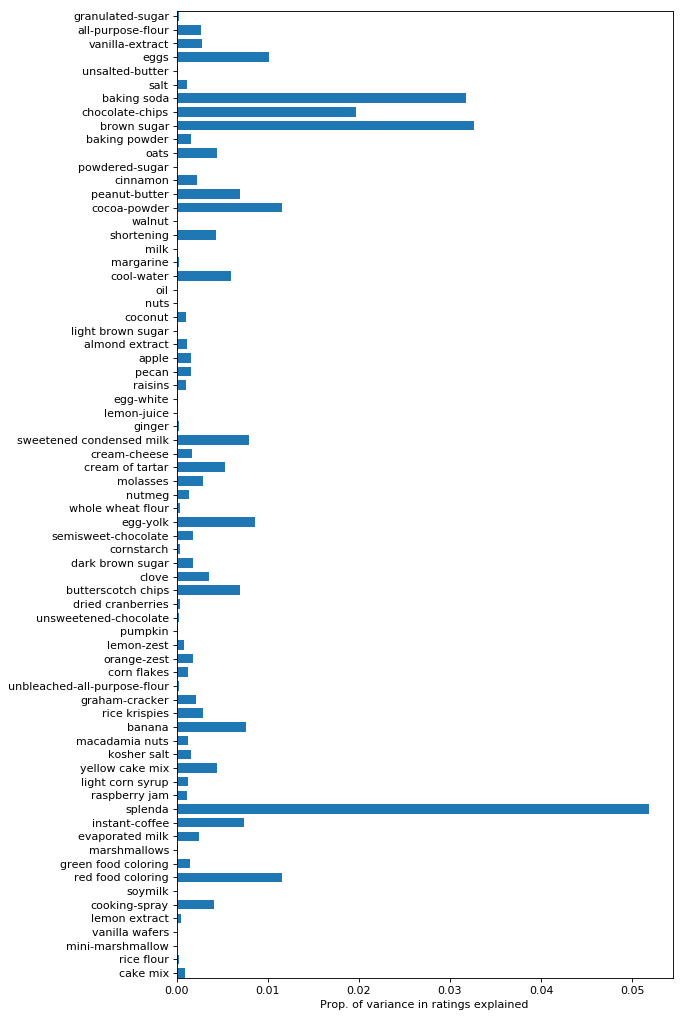

In [14]:
x = np.arange(0,len(rsquare))
plt.figure(figsize=(8, 16), dpi=80)
plt.barh(y=x, width=np.flipud(rsquare), height=.7)

plt.yticks(x, np.flipud(labels_sort[:n]))
plt.xlabel('Prop. of variance in ratings explained')
plt.margins(y=0)